# Training Comparisons and Evaluations

##### Authors:
1. Ovidio Manteiga Moar
1. Carlos Villar Martínez

In this notebook the goal is to train a GAN. In this case we are going to use grayscale, in the rest we are going to use the colour images. The process is similar in all GANs so it will just be explained in this one in detail.

In [9]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, utils, metrics, optimizers
from Data_pre import prepare_data_generator_GAN

from utils import display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


First of all we load the data from the folder, in this case this is our directory but it may be different depending on the computer.

In [10]:
DATA_FOLDER = "./Dataset/img_align_celeba"

Now we define some hyperparameters, this is an important step because depending on the hyperparameters that we use the results are going to be better or worse. There is not a magic formula to find the best combination of hyperparameters it is all a matter of trial and error. In this practise this fact is a bit annoying because the trainning of the GAN is something that takes plenty of time and every time you want to try a different combination it might take ten hours.

In [11]:
IMAGE_SIZE = 64
CHANNELS = 1

BATCH_SIZE = 1024
NUM_FEATURES = 64
Z_DIM = 100

EPOCHS = 5
STEPS_PER_EPOCH=100

LEARNING_RATE = 0.0002
CRITIC_STEPS = 3

ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999

GP_WEIGHT = 10.0
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9

#COLOR_MODE "rgb" or "graysacale"
COLOR_MODE = "grayscale"

In the following cell we do all the data pre processing. We call a function defined in the Data_pre.py file that is the following one: 

```python
def prepare_data_generator_GAN(data_folder, image_size, batch_size, color_mode):

    # Load the data
    train_data = tf.keras.utils.image_dataset_from_directory(
        data_folder,
        labels=None,
        color_mode=color_mode,
        image_size=(image_size, image_size),
        batch_size=batch_size,
        shuffle=True,
        seed=42,
        interpolation="bilinear"
    )

    # Repeat the dataset
    train_data = train_data.repeat()

    # Preprocess the data
    def preprocess(img):
        img = (tf.cast(img, "float32") - 127.5) / 127.5
        return img

    train = train_data.map(lambda x: preprocess(x))

    return train

```

We basically load and normalize the data with funciton.

In [12]:
train = prepare_data_generator_GAN(DATA_FOLDER, IMAGE_SIZE, BATCH_SIZE, COLOR_MODE)

Found 202599 files belonging to 1 classes.


##### Building tthe WGAN-GP

Now we have to build the WGAN, as we know we need two different parts, the generator and the discriminator. In order to do this we have to create two different models. The main idea is that the geenerator generates faces and the discriminator has to differenciate if they are real or fake. 

In [13]:
critic_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same")(critic_input)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(256, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(512, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(1, kernel_size=4, strides=1, padding="valid")(x)
critic_output = layers.Flatten()(x)

critic = models.Model(critic_input, critic_output)
critic.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1088      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         524544

In [14]:
generator_input = layers.Input(shape=(Z_DIM,))
x = layers.Reshape((1, 1, Z_DIM))(generator_input)
x = layers.Conv2DTranspose(512, kernel_size=4, strides=1, padding="valid", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
generator_output = layers.Conv2DTranspose(CHANNELS, kernel_size=4, strides=2, padding="same", activation="tanh")(x)
generator = models.Model(generator_input, generator_output)
generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 reshape (Reshape)           (None, 1, 1, 100)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 512)        819200    
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 4, 4, 512)        2048      
 ormalization)                                                   
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 8, 8, 256)        2097

In [15]:
class WGANGP(models.Model):
    def __init__(self, critic, generator, latent_dim, critic_steps, gp_weight):
        super(WGANGP, self).__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.critic_steps = critic_steps
        self.gp_weight = gp_weight

    def compile(self, c_optimizer, g_optimizer):
        super(WGANGP, self).compile()
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer
        self.c_wass_loss_metric = metrics.Mean(name="c_wass_loss")
        self.c_gp_metric = metrics.Mean(name="c_gp")
        self.c_loss_metric = metrics.Mean(name="c_loss")
        self.g_loss_metric = metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.c_loss_metric, self.c_wass_loss_metric, self.c_gp_metric, self.g_loss_metric]

    def gradient_penalty(self, batch_size, real_images, fake_images):
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.critic(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        for i in range(self.critic_steps):
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

            with tf.GradientTape() as tape:
                fake_images = self.generator(random_latent_vectors, training=True)
                fake_predictions = self.critic(fake_images, training=True)
                real_predictions = self.critic(real_images, training=True)

                c_wass_loss = tf.reduce_mean(fake_predictions) - tf.reduce_mean(real_predictions)
                c_gp = self.gradient_penalty(batch_size, real_images, fake_images)
                c_loss = c_wass_loss + c_gp * self.gp_weight

            c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(zip(c_gradient, self.critic.trainable_variables))

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_latent_vectors, training=True)
            fake_predictions = self.critic(fake_images, training=True)
            g_loss = -tf.reduce_mean(fake_predictions)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))

        """
        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)

        return {m.name: m.result() for m in self.metrics}
        """
    
    
    
      # Calculate Critic and Generator Accuracy
        c_acc = tf.reduce_mean(tf.cast(tf.math.greater(real_predictions, 0), tf.float32)) * 100
        g_acc = tf.reduce_mean(tf.cast(tf.math.less(fake_predictions, 0), tf.float32)) * 100

        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)

        #return {m.name: m.result() for m in self.metrics,'c_acc': c_acc,'g_acc': g_acc}    
        return {**{m.name: m.result() for m in self.metrics}, 'c_acc': c_acc, 'g_acc': g_acc}

In [16]:
# Create a GAN
wgangp = WGANGP(critic=critic, generator=generator, latent_dim=Z_DIM, critic_steps=CRITIC_STEPS, gp_weight=GP_WEIGHT)

In [17]:
if LOAD_MODEL:
    wgangp.load_weights("./checkpoint/checkpoint.ckpt")

##### Training the GAN

Once we have everything done we can start trainning the WGAN.

In [18]:
# Compile the GAN
wgangp.compile(
    c_optimizer=optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2),
    g_optimizer=optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2),
)

In [19]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


real_images = np.array(list(train.unbatch().take(10).as_numpy_iterator()))
print(real_images.shape)
print(real_images[0].shape)
from fid import get_fid

class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.history = { 'fid': [] }

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        display(generated_images, save_to="./output/generated_img_%03d.png" % (epoch), cmap=None)
        fid = get_fid(real_images, generated_images)
        self.history['fid'].append(fid)

(10, 64, 64, 1)
(64, 64, 1)


In [20]:
class LossHistory(callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.history = {
            'c_loss': [],
            'g_loss': [],
            'c_acc': [],
            'g_acc': [],
        }

    def on_epoch_end(self, epoch, logs=None):
        self.history['c_loss'].append(logs['c_loss'])
        self.history['g_loss'].append(logs['g_loss'])
        self.history['c_acc'].append(logs['c_acc'])
        self.history['g_acc'].append(logs['g_acc'])

loss_history = LossHistory()

Epoch 1/5
100/100 [==============================] - ETA: 0s - c_loss: -19.5400 - c_wass_loss: -25.5571 - c_gp: 0.6017 - g_loss: -0.8644 - c_acc: 97.2568 - g_acc: 48.3174  
Saved to ./output/generated_img_000.png


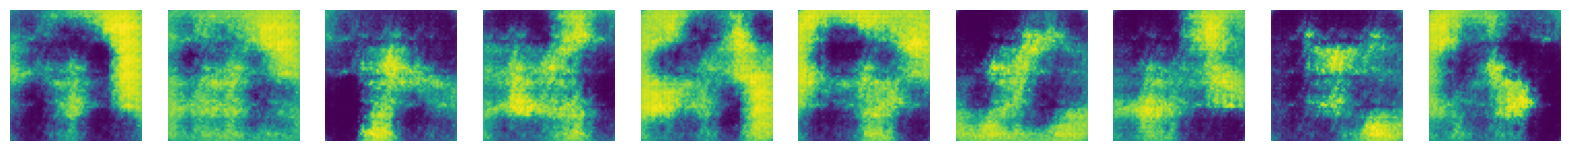

Loaded (10, 64, 64, 1) (10, 64, 64, 1)
Scaled (10, 299, 299, 3) (10, 299, 299, 3)
1/1 [==============================] - 1s 931ms/step
FID: 551.915
100/100 [==============================] - 11639s 115s/step - c_loss: -19.5400 - c_wass_loss: -25.5571 - c_gp: 0.6017 - g_loss: -0.8644 - c_acc: 97.2840 - g_acc: 47.8390
Epoch 2/5
100/100 [==============================] - ETA: 0s - c_loss: -6.4379 - c_wass_loss: -7.1011 - c_gp: 0.0663 - g_loss: -39.4652 - c_acc: 100.0000 - g_acc: 0.0059  
Saved to ./output/generated_img_001.png


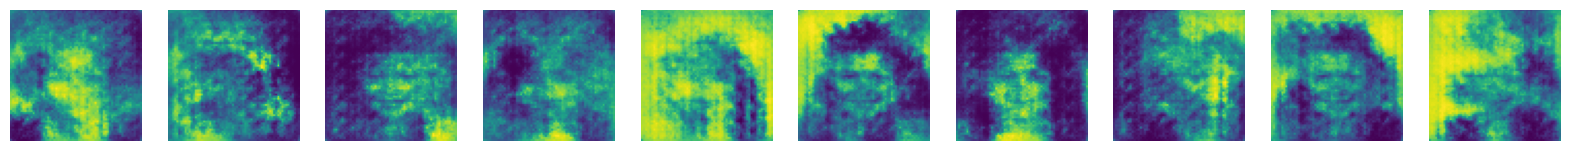

Loaded (10, 64, 64, 1) (10, 64, 64, 1)
Scaled (10, 299, 299, 3) (10, 299, 299, 3)
1/1 [==============================] - 1s 895ms/step
FID: 591.218
100/100 [==============================] - 15402s 154s/step - c_loss: -6.4379 - c_wass_loss: -7.1011 - c_gp: 0.0663 - g_loss: -39.4652 - c_acc: 100.0000 - g_acc: 0.0058
Epoch 3/5
100/100 [==============================] - ETA: 0s - c_loss: -5.8156 - c_wass_loss: -6.4051 - c_gp: 0.0589 - g_loss: -38.5984 - c_acc: 100.0000 - g_acc: 0.0107  
Saved to ./output/generated_img_002.png


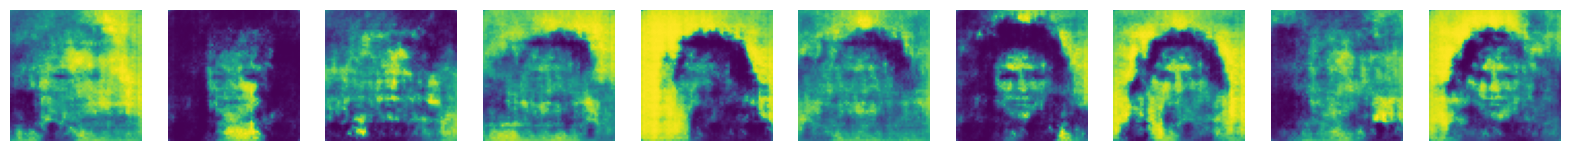

Loaded (10, 64, 64, 1) (10, 64, 64, 1)
Scaled (10, 299, 299, 3) (10, 299, 299, 3)
1/1 [==============================] - 1s 1s/step
FID: 576.310
100/100 [==============================] - 11670s 117s/step - c_loss: -5.8156 - c_wass_loss: -6.4051 - c_gp: 0.0589 - g_loss: -38.5984 - c_acc: 100.0000 - g_acc: 0.0106
Epoch 4/5
100/100 [==============================] - ETA: 0s - c_loss: -5.4054 - c_wass_loss: -5.9404 - c_gp: 0.0535 - g_loss: -23.4110 - c_acc: 99.9873 - g_acc: 0.4609  
Saved to ./output/generated_img_003.png


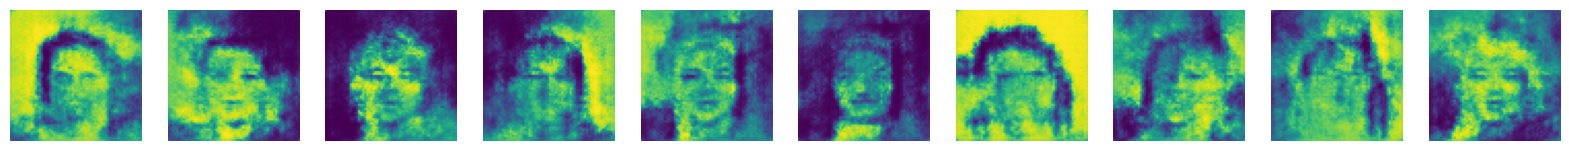

Loaded (10, 64, 64, 1) (10, 64, 64, 1)
Scaled (10, 299, 299, 3) (10, 299, 299, 3)
1/1 [==============================] - 1s 983ms/step
FID: 597.796
100/100 [==============================] - 16557s 166s/step - c_loss: -5.4054 - c_wass_loss: -5.9404 - c_gp: 0.0535 - g_loss: -23.4110 - c_acc: 99.9874 - g_acc: 0.4573
Epoch 5/5
100/100 [==============================] - ETA: 0s - c_loss: -4.6170 - c_wass_loss: -5.0634 - c_gp: 0.0446 - g_loss: -13.0019 - c_acc: 98.4268 - g_acc: 6.9736  
Saved to ./output/generated_img_004.png


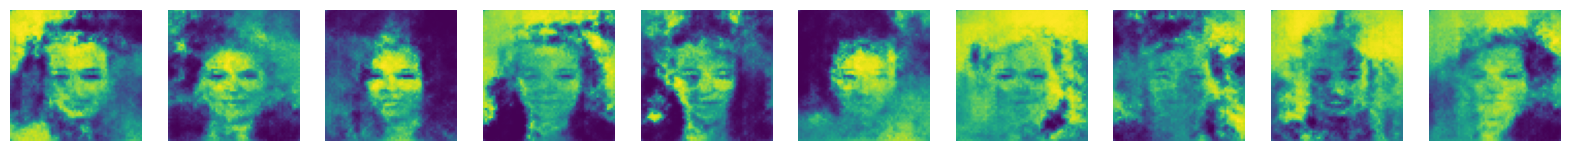

Loaded (10, 64, 64, 1) (10, 64, 64, 1)
Scaled (10, 299, 299, 3) (10, 299, 299, 3)
1/1 [==============================] - 1s 1s/step
FID: 647.623
100/100 [==============================] - 12176s 122s/step - c_loss: -4.6170 - c_wass_loss: -5.0634 - c_gp: 0.0446 - g_loss: -13.0019 - c_acc: 98.4423 - g_acc: 6.9143


In [21]:
loss_history = LossHistory()

wgangp.fit(
    train,
    #train.take(1),
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    #steps_per_epoch=1,
    callbacks=[model_checkpoint_callback, tensorboard_callback, ImageGenerator(num_img=10, latent_dim=Z_DIM), loss_history],
)

In [22]:
# Save the model to explore latent space
# It doesn't work with subclassed models.

# tf.saved_model.save(wgangp, "models/wgangp")


##### Generate the images

1/1 [==============================] - 0s 475ms/step


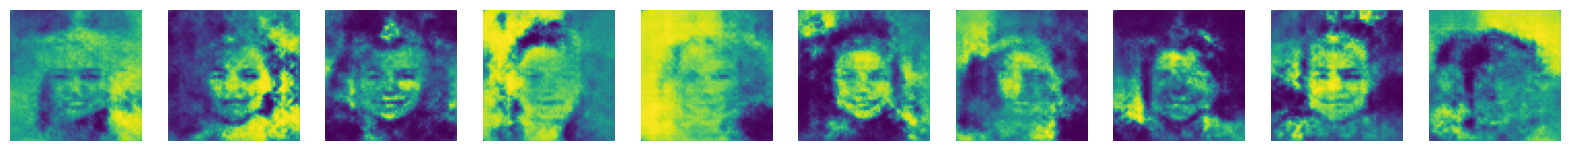

In [23]:
z_sample = np.random.normal(size=(10, Z_DIM))
imgs = wgangp.generator.predict(z_sample)
display(imgs, cmap=None)

As we can see in the generated images, we can sense faces but they are not even close to something that could be confuse with a real face. We have to take into account that wejust used five epochs in the trainning fase. 

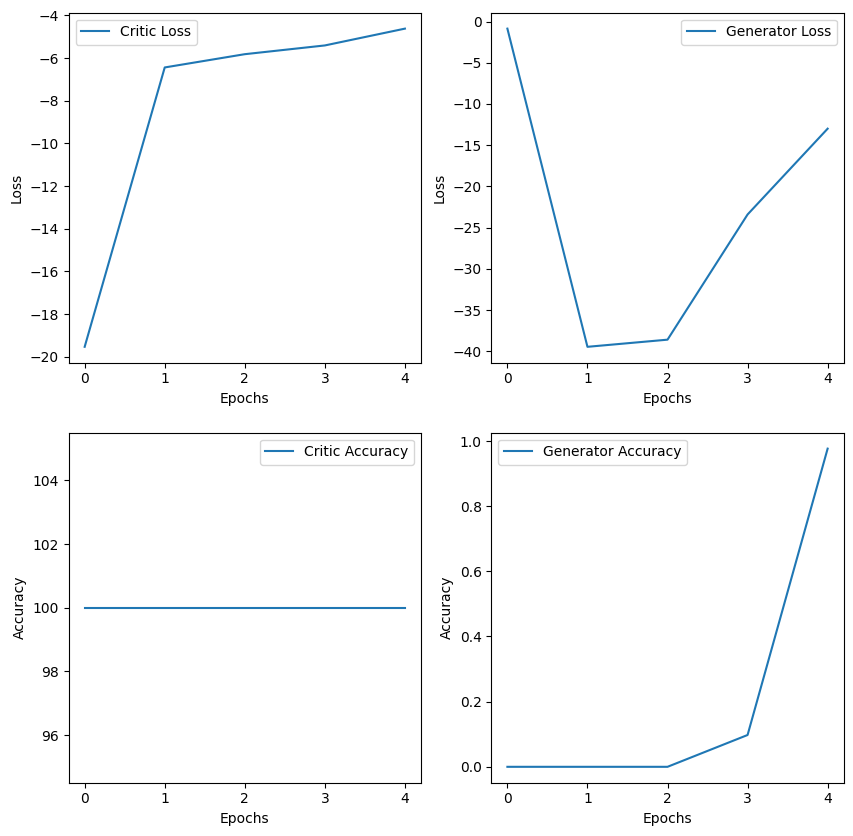

In [24]:
import matplotlib.pyplot as plt

def plot_losses_and_accuracy(loss_history):
    epochs = len(loss_history.history['c_loss'])
    x = range(epochs)

    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    
    axs[0, 0].plot(x, loss_history.history['c_loss'], label="Critic Loss")
    axs[0, 0].set(xlabel="Epochs", ylabel="Loss")
    axs[0, 0].legend()
    
    axs[0, 1].plot(x, loss_history.history['g_loss'], label="Generator Loss")
    axs[0, 1].set(xlabel="Epochs", ylabel="Loss")
    axs[0, 1].legend()
    
    axs[1, 0].plot(x, loss_history.history['c_acc'], label="Critic Accuracy")
    axs[1, 0].set(xlabel="Epochs", ylabel="Accuracy")
    axs[1, 0].legend()
    
    axs[1, 1].plot(x, loss_history.history['g_acc'], label="Generator Accuracy")
    axs[1, 1].set(xlabel="Epochs", ylabel="Accuracy")
    axs[1, 1].legend()

    plt.show()

plot_losses_and_accuracy(loss_history)